In [ ]:
!nvidia-smi

Sun Oct 22 18:54:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P2    40W /  N/A |    833MiB / 16125MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# <font color = 'pickle'>**Translation** </font>







## Outline
1. **Setting up the Environment**: Installing necessary libraries and setting up paths.
2. **Exploring and Understanding IMDB Dataset**: Understanding the structure and content of the dataset.

3. **Data Preprocessing**: Techniques to prepare the data for training, including handling different data splits and tokenization
4. **Training the Model**: Feeding data and adjusting weights.
5. **Prediction and Evaluation**: Evaluate model on test set and making predictions.



# <font color = 'pickle'> **Setting up the Environment** </font>

In [ ]:
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder = Path("/content/drive/MyDrive/data")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")


from transformers import AutoConfig, AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainer
from transformers import AutoTokenizer, DataCollatorForSeq2Seq, pipeline
from datasets import load_dataset, DatasetDict
import evaluate
from evaluate import evaluator


import wandb
import numpy as np
import pandas as pd

2023-10-22 18:54:30.378927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# <font color = 'pickle'> **Exploring and Understanding Dataset**

## <font color = 'pickle'> **English_French_Translation**</font>



## <font color = 'pickle'> **Load Data set**
    


In [ ]:
kde_dataset = load_dataset('kde4', lang1='en', lang2='fr')

## <font color = 'pickle'> **Understanding your data**

In [ ]:
print(kde_dataset)


DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})


## <font color = 'pickle'> **Understanding the datatype of columns**


In [ ]:
kde_dataset["train"].features


{'id': Value(dtype='string', id=None),
 'translation': Translation(languages=['en', 'fr'], id=None)}

## <font color = 'pickle'> **Acess indivdual element** </font>
 The dataset behaves like an Python array or list. We can use the familiar indexing/slicing methods to access individual elements.

In [ ]:
# get the first example of the dataset
kde_dataset["train"][42]


{'id': '42',
 'translation': {'en': 'The Embedded Media Player',
  'fr': 'Le Lecteur de Média incorporé'}}

The dialogues resemble typical SMS or WhatsApp chats, complete with emojis and spaces for GIFs. The "dialogue" field presents the entire text, while the "summary" field provides the summary of the conversation.

## <font color = 'pickle'> **Exploratory Data Analysis (EDA)**

### <font color = 'pickle'> **Change dataset format to Pandas**  </font>


In [ ]:
# This will convert all the splits into Pandas dataframe
kde_dataset.set_format(type="pandas")


In [ ]:
# Get all rows from training split
df_train = kde_dataset["train"][:]


In [ ]:
df_train.head()


,id,translation
0,0,"{'en': 'Lauri Watts', 'fr': 'Lauri Watts'}"
1,1,"{'en': '& Lauri. Watts. mail;', 'fr': '& Lauri..."
2,2,"{'en': 'ROLES_OF_TRANSLATORS', 'fr': '& traduc..."
3,3,"{'en': '2006-02-26 3.5.1', 'fr': '2006-02-26 3..."
4,4,{'en': 'The Babel & konqueror; plugin gives yo...


In [ ]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210173 entries, 0 to 210172
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           210173 non-null  object
 1   translation  210173 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


### <font color = 'pickle'> **Check length of the dialogue/summary** </font>


In [ ]:
df_train['words_per_sent_en'] = df_train['translation'].apply(lambda x: len(x['en'].split()))
df_train['words_per_sent_fr'] = df_train['translation'].apply(lambda x: len(x['fr'].split()))

In [ ]:
df_train.head()


,id,translation,words_per_sent_en,words_per_sent_fr
0,0,"{'en': 'Lauri Watts', 'fr': 'Lauri Watts'}",2,2
1,1,"{'en': '& Lauri. Watts. mail;', 'fr': '& Lauri...",4,4
2,2,"{'en': 'ROLES_OF_TRANSLATORS', 'fr': '& traduc...",1,2
3,3,"{'en': '2006-02-26 3.5.1', 'fr': '2006-02-26 3...",2,2
4,4,{'en': 'The Babel & konqueror; plugin gives yo...,14,17


#### <font color = 'pickle'> **Plot the distribution of review length** </font>

In [ ]:
import matplotlib.pyplot as plt


def plot_two_hists(series1, series2, label1, label2):
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the first histogram on the left subplot
    axs[0].hist(series1, bins=50, edgecolor="black")
    axs[0].set_xlabel("Number of Words")
    axs[0].set_ylabel("Frequency")
    axs[0].set_title(f"Distribution of Words per {label1}")

    # Plot the second histogram on the right subplot
    axs[1].hist(series2, bins=50, edgecolor="black")
    axs[1].set_xlabel("Number of Words")
    axs[1].set_ylabel("Frequency")
    axs[1].set_title(f"Distribution of Words per {label2}")

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3)

    # Display the plot
    plt.show()


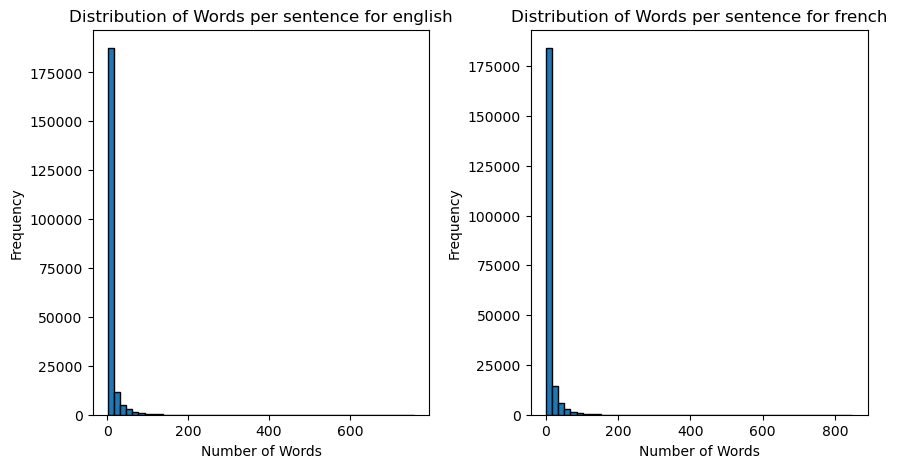

In [ ]:
plot_two_hists(
    df_train["words_per_sent_en"], df_train["words_per_sent_fr"], "sentence for english", "sentence for french"
)


In [ ]:
df_train["words_per_sent_en"].describe()

count    210173.000000
mean          7.573218
std          14.894992
min           1.000000
25%           2.000000
50%           3.000000
75%           6.000000
max         759.000000
Name: words_per_sent_en, dtype: float64

In [ ]:
# Let us check how many sentences ahs more than 500 words

count = (df_train["words_per_sent_en"] > 500).sum()
print(f"Number of sentences with more than 400 words: {count}")


Number of sentences with more than 400 words: 5


In [ ]:
# Let us check how many sentences has less than 2 words

count = (df_train["words_per_sent_en"] <2).sum()
print(f"Number of sentences with less than 2 words: {count}")

Number of sentences with less than 2 words: 48165


In [ ]:
# Let us check how many sentences has less than 1 word - empty strings

count = (df_train["words_per_sent_en"] <1).sum()
print(f"Number of sentences with less than 2 words: {count}")

Number of sentences with less than 2 words: 0


In [ ]:
df_train[df_train["words_per_sent_fr"]<2]

,id,translation,words_per_sent_en,words_per_sent_fr
5,5,"{'en': 'KDE', 'fr': 'KDE'}",1,1
6,6,"{'en': 'kdeaddons', 'fr': 'kdeaddons'}",1,1
7,7,"{'en': 'konqueror', 'fr': 'konqueror'}",1,1
9,9,"{'en': 'babelfish', 'fr': 'babelfish'}",1,1
10,10,"{'en': 'translate', 'fr': 'traduction'}",1,1
...,...,...,...,...
210137,210137,"{'en': 'Games', 'fr': 'JeuxPhonon::'}",1,1
210138,210138,"{'en': 'Accessibility', 'fr': 'Accessibilité'}",1,1
210156,210156,"{'en': 'aRts', 'fr': 'aRts'}",1,1
210161,210161,"{'en': 'Volume', 'fr': 'Volume'}",1,1


### <font color = 'pickle'> **Reset dataset format** </font>


In [ ]:
kde_dataset.reset_format()


In [ ]:
kde_dataset


DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

# <font color = 'pickle'> **Data Pre-processing**</font>

## <font color = 'indianred'> **Create train, valid, test splits** </font>

In [ ]:
test_val_splits = kde_dataset['train'].train_test_split(test_size=0.4, seed=42)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
val_split = test_val_splits['train']
test_split = test_val_splits['test']

## <font color = 'indianred'> **Create small subset for experimentation** </font>


In [ ]:
train_split_small = train_split.shuffle(seed=42).select(range(1000))
val_split_small = val_split.shuffle(seed=42).select(range(500))
test_split_small = test_split.shuffle(seed=42).select(range(500))

In [ ]:
# combine train, val splits into one dataset
train_val_subset = DatasetDict({'train': train_split_small, 'val': val_split_small})

# create test dataset from test split
test_subset= DatasetDict({'test': test_split_small})

In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['id', 'translation'],
        num_rows: 500
    })
})

In [ ]:
test_subset

DatasetDict({
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 500
    })
})

In [ ]:
train_val_subset["train"]["translation"][1]


{'en': 'Upper Window: View on Printers, both Real and Virtual',
 'fr': "Fenêtre supérieure & #160;: Vue de l'ensemble des imprimantes, réelles et virtuelles"}

## <font color = 'pickle'> **Tokenization**</font>

###  <font color = 'pickle'> **Load pre-trained Tokenizer** </font>

In [ ]:
checkpoint = 'Helsinki-NLP/opus-mt-en-fr'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


In [ ]:
# tokenizer??

### <font color = 'pickle'> **Understanding tokenizer**</font>

In [ ]:
text = [
    "Upper Window: View on Printers, both Real and Virtual",
    "Fenêtre supérieure & #160;: Vue de l'ensemble des imprimantes, réelles et virtuelles",
]


In [ ]:
# get the vocab size
print(f"Pretrained tokenizer vocab size {tokenizer.vocab_size}")


Pretrained tokenizer vocab size 59514


In [ ]:
encoded_text = tokenizer(
    text, padding=True, truncation=True, return_tensors="pt")


In [ ]:
encoded_text


{'input_ids': tensor([[21364, 38007,    37,  3689,    30, 36712,     9,     2,   533,  7770,
            10, 21821,     0, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513],
        [37412,   501,    62,   746, 32076,  1935,   402, 30362,  2069,    50,
            37,   461,  3773,     5,    14,     6,  8409,   122,  4995,    13,
          3497, 11585,  3172,     9,     2,   906,  1295,    11, 13747,   477,
           114,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
tokens_first_sentence = tokenizer.convert_ids_to_tokens(
    encoded_text.input_ids[0])
tokens_second_sentence = tokenizer.convert_ids_to_tokens(
    encoded_text.input_ids[1])

print(tokens_first_sentence)
print(tokens_second_sentence)


['▁Upper', '▁Window', ':', '▁View', '▁on', '▁Printer', 's', ',', '▁both', '▁Real', '▁and', '▁Virtual', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['▁Fen', 'être', '▁s', 'up', 'érie', 'ure', '▁&', '▁#1', '60', ';', ':', '▁V', 'ue', '▁de', '▁l', "'", 'ense', 'm', 'ble', '▁des', '▁imp', 'rim', 'ante', 's', ',', '▁ré', 'elles', '▁et', '▁virtue', 'll', 'es', '</s>']


In [ ]:
tokenizer.convert_tokens_to_string(tokens_first_sentence)


'▁Upper▁Window: View on▁Printers,▁both Real and▁Virtual</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [ ]:
tokenizer.convert_tokens_to_string(tokens_second_sentence)

"▁Fenêtre supérieure &▁#160;: Vue de l'ensemble des imprimantes, réelles et▁virtuelles</s>"

In [ ]:
special_tokens = tokenizer.all_special_tokens
special_tokens_ids = tokenizer.all_special_ids


In [ ]:
import pandas as pd


In [ ]:
df = pd.DataFrame(
    {"special_tokens": special_tokens, "special_tokens_ids": special_tokens_ids}
)


In [ ]:
pd.set_option("display.max_rows", None)


In [ ]:
df


,special_tokens,special_tokens_ids
0,</s>,0
1,<unk>,1
2,<pad>,59513


###  <font color = 'pickle'> **Create function for Tokenizer**

In [ ]:
# we do not need to add padding
# padding and conversion to Pytorch Tensor is handled by the data collators
# in more efficient manner

max_length = 128
def tokenize_fn(batch):
    # CODE HERE
    


###  <font color = 'pickle'> **Use map function to apply tokenization to all splits**

In [ ]:
tokenized_dataset = train_val_subset.map(tokenize_fn,
                              batched = True,
                              remove_columns=train_val_subset['train'].column_names)

In [ ]:
tokenized_dataset.set_format(type="torch")


In [ ]:
tokenized_dataset


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
})

In [ ]:
tokenized_dataset["train"].features


{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
print(len(tokenized_dataset["train"]["input_ids"][2]))
print(len(tokenized_dataset["train"]["input_ids"][1]))


2
13


In [ ]:
print(
    tokenizer.convert_ids_to_tokens(
        tokenized_dataset["train"]["input_ids"][0][0:10]
    )
)


['▁I', 'dent', 'ifier', ':', '</s>']


In [ ]:
print(
    tokenizer.convert_ids_to_tokens(
        tokenized_dataset["train"]["labels"][0][0:10])
)


['▁Identifiant', '▁&', '▁#160;:', '</s>']


#  <font color = 'pickle'> **Model Training**

##  <font color = 'pickle'> **Model Config File**</font>



In [ ]:
config = AutoConfig.from_pretrained(checkpoint)

In [ ]:
config

MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-en-fr",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 59513,
  "decoder_vocab_size": 59514,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    

In [ ]:
from transformers import GenerationConfig

# generation_config = GenerationConfig.from_model_config(config)
generation_config = GenerationConfig.from_pretrained(checkpoint)


In [ ]:
generation_config


GenerationConfig {
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "decoder_start_token_id": 59513,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "max_length": 512,
  "num_beams": 4,
  "pad_token_id": 59513,
  "renormalize_logits": true,
  "transformers_version": "4.30.2"
}

##  <font color = 'pickle'> **Download pre-trained model**

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(
    checkpoint,
    config=config,
)


## <font color = 'pickle'> **Model Input/Collate Function** </font>

In [ ]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
)


In [ ]:
train_val_subset['train'][100]


{'id': '34366',
 'translation': {'en': 'Basic Command Set',
  'fr': 'Ensemble de commandes basiques'}}

In [ ]:
features = [tokenized_dataset["train"][i] for i in range(3)]
features


[{'input_ids': tensor([  47, 9314, 8245,   37,    0]),
  'attention_mask': tensor([1, 1, 1, 1, 1]),
  'labels': tensor([41612,   402, 38492,     0])},
 {'input_ids': tensor([21364, 38007,    37,  3689,    30, 36712,     9,     2,   533,  7770,
             10, 21821,     0]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'labels': tensor([  304,   162,   501,  4517,   402, 38492, 14781,     5,    14,     6,
           1420,    13, 29719,     9,     2, 12782,    11, 18769,     9,     0])},
 {'input_ids': tensor([41704,     0]),
  'attention_mask': tensor([1, 1]),
  'labels': tensor([12323,     0])}]

In [ ]:
model_input = data_collator(features)
model_input.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

<font color='indianred'>• Notice that data_collator has added the <strong>decoder_input_ids</strong></font>


In [ ]:
print(model_input)


{'input_ids': tensor([[   47,  9314,  8245,    37,     0, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513],
        [21364, 38007,    37,  3689,    30, 36712,     9,     2,   533,  7770,
            10, 21821,     0],
        [41704,     0, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'labels': tensor([[41612,   402, 38492,     0,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
        [  304,   162,   501,  4517,   402, 38492, 14781,     5,    14,     6,
          1420,    13, 29719,     9,     2, 12782,    11, 18769,     9,     0],
        [12323,     0,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100]])

<font color='indianred'>• **Note that 59513 is both the start token and pad token for the decoder input ids**</font>

<font color='indianred'>•  **Also note that decoder input ids are shifted version of the labels**


In [ ]:
print(model_input.decoder_input_ids[0][0:10])
print(model_input.labels[0][0:10])

tensor([59513, 41612,   402, 38492,     0, 59513, 59513, 59513, 59513, 59513])
tensor([41612,   402, 38492,     0,  -100,  -100,  -100,  -100,  -100,  -100])


In [ ]:
print(model_input.decoder_input_ids[0][-20:])
print(model_input.labels[0][-20:])


tensor([59513, 41612,   402, 38492,     0, 59513, 59513, 59513, 59513, 59513,
        59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513])
tensor([41612,   402, 38492,     0,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])


In [ ]:
print(model_input.decoder_input_ids[1][0:10])
print(model_input.labels[1][0:10])


tensor([59513,   304,   162,   501,  4517,   402, 38492, 14781,     5,    14])
tensor([  304,   162,   501,  4517,   402, 38492, 14781,     5,    14,     6])


In [ ]:
print(model_input.decoder_input_ids[1][-20:])
print(model_input.labels[1][-20:])


tensor([59513,   304,   162,   501,  4517,   402, 38492, 14781,     5,    14,
            6,  1420,    13, 29719,     9,     2, 12782,    11, 18769,     9])
tensor([  304,   162,   501,  4517,   402, 38492, 14781,     5,    14,     6,
         1420,    13, 29719,     9,     2, 12782,    11, 18769,     9,     0])


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.decoder_input_ids[0][0:10]))
print(tokenizer.convert_ids_to_tokens(model_input.labels[0][0:10]))


['<pad>', '▁Identifiant', '▁&', '▁#160;:', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['▁Identifiant', '▁&', '▁#160;:', '</s>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.decoder_input_ids[0][-20:]))
try:
    print(tokenizer.convert_ids_to_tokens(model_input.labels[0][-20:]))
except:
    print(f"No tokens corresponding to ids")


['<pad>', '▁Identifiant', '▁&', '▁#160;:', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['▁Identifiant', '▁&', '▁#160;:', '</s>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


##  <font color = 'pickle'> **Understanding Model Output**


In [ ]:
# model output
model_output = model(**model_input)


In [ ]:
# keys in model output
model_output.keys()


odict_keys(['loss', 'logits', 'encoder_last_hidden_state'])

In [ ]:
# let us look at logits
model_output.logits.shape

torch.Size([3, 20, 59514])

In [ ]:
logits = model_output.logits.detach().cpu().numpy()

In [ ]:
# Greedy decoding
preds = np.argmax(logits, axis = -1)

In [ ]:
preds.shape

(3, 20)

In [ ]:
preds

array([[16235,    37, 38492,     0,     0,     0,     0,     0,     0,
           47,    47,    47,    47,    47,    47,    47,    47,    47,
           47,    47],
       [  304,   162,   501,  4517,    78, 38492,   498,    36,    14,
            6, 41599,    13, 29719,     9,     2, 12782,    11, 18769,
            9,     0],
       [12323,     0,     0,     0,     0,     0, 12323, 12323, 12323,
        12323, 12323, 12323, 12323, 12323, 12323, 12323, 12323, 12323,
        12323, 12323]])

In [ ]:
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(preds[0]))

'Identification: #160;:</s> </s> </s> </s> </s> </s> I I I I I I I I I I I'

In [ ]:
def get_label_strings(labels):
    return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(labels))

In [ ]:
labels = [get_label_strings(label) for label in model_input['labels']]

In [ ]:
labels

['Identifiant & #160;:</s> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>',
 "Fenêtre supérieure & #160;: Vue de l'ensemble des imprimantes, réelles et virtuelles</s>",
 'Aperçu</s> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>']

In [ ]:
preds = [ get_label_strings(pred) for pred in preds]
preds

['Identification: #160;:</s> </s> </s> </s> </s> </s> I I I I I I I I I I I',
 "Fenêtre supérieure : #160;: vue sur l'imprimante des imprimantes, réelles et virtuelles</s>",
 'Aperçu</s> </s> </s> </s> </s> Aperçu Aperçu Aperçu Aperçu Aperçu Aperçu Aperçu Aperçu Aperçu Aperçu Aperçu Aperçu Aperçu Aperçu']

In [ ]:
final_string_preds=[]
for example in preds:
    string_preds =[]
    for s in example.split():
        string_preds.append(s)
        if '</s>' in s:
            break
    final_string_preds.append(' '.join(string_preds))

final_string_preds

['Identification: #160;:</s>',
 "Fenêtre supérieure : #160;: vue sur l'imprimante des imprimantes, réelles et virtuelles</s>",
 'Aperçu</s>']

In [ ]:
# generate prediction from logits using beam search
generated_predictions = model.generate(
    **model_input, generation_config=generation_config, max_length=128
)


In [ ]:
generated_predictions.shape


torch.Size([3, 25])

In [ ]:
generated_predictions


tensor([[59513, 41612,   402, 38492,     0, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
            47,  9314, 18458,    37,     0],
        [59513,   304,   162,   501,  4517,   402, 38492, 14781,     5,    14,
             6,  1420,    13, 29719,     9,     2, 12782,    11, 18769,     9,
             0, 59513, 59513, 59513, 59513],
        [59513, 12323,     0, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         12323,     0, 59513, 59513, 59513]])

In [ ]:
generated_predictions.shape


torch.Size([3, 25])

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(generated_predictions[0])
print(tokens)


['<pad>', '▁Identifiant', '▁&', '▁#160;:', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '▁I', 'dent', 'ificateur', ':', '</s>']


In [ ]:
translation = tokenizer.convert_tokens_to_string(tokens)
print(translation)


<pad> Identifiant & #160;:</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> Identificateur:</s>


In [ ]:
tokenizer.decode(generated_predictions[1])


"<pad> Fenêtre supérieure & #160;: Vue de l'ensemble des imprimantes, réelles et virtuelles</s> <pad> <pad> <pad> <pad>"

In [ ]:
tokenizer.decode(generated_predictions[1], skip_special_tokens=True)


"Fenêtre supérieure & #160;: Vue de l'ensemble des imprimantes, réelles et virtuelles"

In [ ]:
# decode tokens to generate translation
tokenizer.batch_decode(generated_predictions)


['<pad> Identifiant & #160;:</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> Identificateur:</s>',
 "<pad> Fenêtre supérieure & #160;: Vue de l'ensemble des imprimantes, réelles et virtuelles</s> <pad> <pad> <pad> <pad>",
 '<pad> Aperçu</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> Aperçu</s> <pad> <pad> <pad>']

In [ ]:
# decode tokens to generate summary
tokenizer.batch_decode(generated_predictions, skip_special_tokens=True)


['Identifiant & #160;: Identificateur:',
 "Fenêtre supérieure & #160;: Vue de l'ensemble des imprimantes, réelles et virtuelles",
 'Aperçu Aperçu']

##  <font color = 'pickle'> **Evaluation metric(s)** </font>

### <font color = 'pickle'> **Function to compute metric** </font>


In [ ]:
bleu_metric = evaluate.load("sacrebleu")
bert_metric = evaluate.load('bertscore')

def compute_metrics(preds_and_labels):
    # CODE HERE
    

## <font color = 'pickle'> **Set up Logger for experiments**</font>


In [ ]:
wandb.login()
# Set project name for logging
%env WANDB_PROJECT = nlp_course_fall_2023-translation


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=nlp_course_fall_2023-translation


## <font color = 'pickle'> **Hyperparameters and Checkpointing**</font>

In [ ]:
from transformers import Seq2SeqTrainingArguments

# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models" / "nlp_fall_2023/kde4/opus-mt-en-fr"

# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = Seq2SeqTrainingArguments(
    # Training-specific configurations
    num_train_epochs=1,  # Total number of training epochs
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-5,  # Step size for the optimizer during training
    optim="adamw_torch",  # Optimizer,
    warmup_steps=10,
    predict_with_generate=True,
    generation_config=generation_config,
    # memory and speed related arguments
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,  # Number of samples per eval batch for each device

    gradient_checkpointing=True,  # memory
    # fp16 = True, # Speed
    # bf16=True,
    # tf32=True, # speed
    # evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy="steps",  # Evaluate model at specified step intervals
    eval_steps=10,  # Perform evaluation every 10 training steps
    # Checkpoint settings
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=10,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # metric_for_best_model=,
    # greater_is_better=,
    # Experiment logging configurations (commented out in this example)
    logging_strategy="steps",
    logging_steps=10,
    report_to="wandb",  # Log metrics and results to Weights & Biases platform
    # Experiment name for Weights & Biases
    run_name="translation-exp1",
)


##  <font color = 'pickle'> **Initialize Trainer**</font>

In [ ]:
# initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)


##  <font color = 'pickle'> **Start Training**

In [ ]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()


1137

In [ ]:
trainer.train()  # start training


  0%|          | 0/63 [00:00<?, ?it/s]

{'loss': 1.5744, 'learning_rate': 5e-05, 'epoch': 0.16}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.6688148975372314, 'eval_bleu_score:': 39.6931583584462, 'eval_bert_score': 0.8628927312493324, 'eval_runtime': 35.9309, 'eval_samples_per_second': 13.916, 'eval_steps_per_second': 0.891, 'epoch': 0.16}
{'loss': 1.5196, 'learning_rate': 4.0566037735849064e-05, 'epoch': 0.32}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.6054363250732422, 'eval_bleu_score:': 39.12967843712367, 'eval_bert_score': 0.862626445710659, 'eval_runtime': 43.2027, 'eval_samples_per_second': 11.573, 'eval_steps_per_second': 0.741, 'epoch': 0.32}
{'loss': 1.5716, 'learning_rate': 3.113207547169811e-05, 'epoch': 0.48}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.5744301080703735, 'eval_bleu_score:': 39.139003954073075, 'eval_bert_score': 0.8644964972138405, 'eval_runtime': 51.1386, 'eval_samples_per_second': 9.777, 'eval_steps_per_second': 0.626, 'epoch': 0.48}
{'loss': 1.7355, 'learning_rate': 2.1698113207547172e-05, 'epoch': 0.63}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.5488277673721313, 'eval_bleu_score:': 39.79979459526378, 'eval_bert_score': 0.8640872890353203, 'eval_runtime': 44.3704, 'eval_samples_per_second': 11.269, 'eval_steps_per_second': 0.721, 'epoch': 0.63}
{'loss': 1.5713, 'learning_rate': 1.2264150943396227e-05, 'epoch': 0.79}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.5343221426010132, 'eval_bleu_score:': 41.12426554165912, 'eval_bert_score': 0.8655417508482933, 'eval_runtime': 54.3942, 'eval_samples_per_second': 9.192, 'eval_steps_per_second': 0.588, 'epoch': 0.79}
{'loss': 1.6332, 'learning_rate': 2.830188679245283e-06, 'epoch': 0.95}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.5268305540084839, 'eval_bleu_score:': 41.43463120346539, 'eval_bert_score': 0.8658450670838356, 'eval_runtime': 54.65, 'eval_samples_per_second': 9.149, 'eval_steps_per_second': 0.586, 'epoch': 0.95}
{'train_runtime': 307.3834, 'train_samples_per_second': 3.253, 'train_steps_per_second': 0.205, 'train_loss': 1.6233694591219463, 'epoch': 1.0}


TrainOutput(global_step=63, training_loss=1.6233694591219463, metrics={'train_runtime': 307.3834, 'train_samples_per_second': 3.253, 'train_steps_per_second': 0.205, 'train_loss': 1.6233694591219463, 'epoch': 1.0})

##  <font color = 'pickle'> **Evaluation**

### <font color = 'pickle'> **Check performance on validation set**</font>

In [ ]:
trainer.evaluate(tokenized_dataset["val"])

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.5268305540084839,
 'eval_bleu_score:': 41.43463120346539,
 'eval_bert_score': 0.8658450670838356,
 'eval_runtime': 55.277,
 'eval_samples_per_second': 9.045,
 'eval_steps_per_second': 0.579,
 'epoch': 1.0}

In [ ]:
wandb.finish()  # stop logging

eval/bert_score,▂▁▅▄▇██
eval/bleu_score:,▃▁▁▃▇██
eval/loss,█▅▃▂▁▁▁
eval/runtime,▁▄▇▄███
eval/samples_per_second,█▅▂▄▁▁▁
eval/steps_per_second,█▅▂▄▁▁▁
train/epoch,▁▁▂▂▄▄▅▅▆▆████
train/global_step,▁▁▂▂▄▄▅▅▆▆████
train/learning_rate,█▇▅▄▂▁
train/loss,▃▁▃█▃▅
train/total_flos,▁


### <font color = 'pickle'> **Check the best saved model**</font>

In [ ]:
# After training, let us check the best checkpoint
# We need this for Predioctions and Evaluations
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split("-")[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 60.


#  <font color = 'pickle'> **Inference**

## <font color = 'pickle'> **Test Set Evaluation**

In [ ]:
model_folder = base_folder / "models" / "nlp_fall_2023/kde4/opus-mt-en-fr"
checkpoint = str(model_folder / "checkpoint-60")
test_subset


DatasetDict({
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 500
    })
})

In [ ]:
test_data_flattened = test_subset["test"].map(lambda example: {'en': example['translation']['en'], 'fr': example['translation']['fr']})


In [ ]:
test_data_flattened

Dataset({
    features: ['id', 'translation', 'en', 'fr'],
    num_rows: 500
})

In [ ]:
task_evaluator = evaluator("translation")
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
eval_results = task_evaluator.compute(
    model_or_pipeline=checkpoint,
    tokenizer=checkpoint,
    data=test_data_flattened,
    input_column='en',
    label_column='fr',
    generation_kwargs=gen_kwargs,
    device=0,
)


In [ ]:
eval_results

{'bleu': 0.4297887382432084,
 'precisions': [0.6963209311993348,
  0.5226165622825331,
  0.4125192406362237,
  0.32389580973952437],
 'brevity_penalty': 0.9152600196375821,
 'length_ratio': 0.9186557189230475,
 'translation_length': 4811,
 'reference_length': 5237,
 'total_time_in_seconds': 73.25119658300537,
 'samples_per_second': 6.825827062543882,
 'latency_in_seconds': 0.14650239316601074}

##  <font color = 'pickle'> **Prediction for individual or small list of examples**

## <font color = 'pickle'> **Create pipelne for inference**

In [ ]:
custom_pipeline = pipeline(
    task="translation",
    model=checkpoint,
    tokenizer=checkpoint,
    device='cpu',
    framework = 'pt'
)


In [ ]:
sample = test_data_flattened["en"][420]
sample


'Find matching recipes'

In [ ]:
translation = custom_pipeline(sample)
translation

[{'translation_text': 'Trouver des recettes correspondantes'}]

In [ ]:
samples = test_data_flattened["en"][420:423]
samples


['Find matching recipes',
 '%1x%2x%3 brick, %4 shuffling moves',
 'The following sections will describe, in detail, each element. Everything from where they can go to what goes in them is layed out in an easy-to-follow manner.']

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
translations = custom_pipeline(samples, **gen_kwargs)
translations


[{'translation_text': 'Trouver des recettes correspondantes'},
 {'translation_text': '%1x%2x%3 brique, %4 mouvements de shuffling'},
 {'translation_text': "Les sections suivantes décrivent, en détail, chaque élément. Tout de l'endroit où ils peuvent aller à ce qui va en eux est exposé de manière facile à suivre."}]

## <font color = 'pickle'> **Prediction for large dataset**

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 400}
custom_pipeline = pipeline(
    task="translation",
    model=checkpoint,
    tokenizer=checkpoint,
    device=0,
    framework = 'pt'
)
translations = custom_pipeline(test_data_flattened['en'], **gen_kwargs, batch_size=16)

In [ ]:
translations


[{'translation_text': 'Haut & Y & #160;:'},
 {'translation_text': '–'},
 {'translation_text': 'Capitaliser le texte sélectionné ou le mot actuel.'},
 {'translation_text': 'Ouvrir & konqueror;.'},
 {'translation_text': 'Chemins de recherche'},
 {'translation_text': 'Réduire à Grayscale'},
 {'translation_text': "L'utilisateur ne peut modifier aucun paramètre sur cette page."},
 {'translation_text': 'Générer'},
 {'translation_text': 'Vietnamien (Vietnam)'},
 {'translation_text': 'Sélectionnez le style à importer & #160;:'},
 {'translation_text': 'Cisco - Hub'},
 {'translation_text': "Impossible de lire l'en-tête de la base de données %1."},
 {'translation_text': 'Serveur trouvé, connexion...'},
 {'translation_text': 'Hôte'},
 {'translation_text': 'Envoyer un & fichier'},
 {'translation_text': 'toute la journée'},
 {'translation_text': 'examen; examens; Em'},
 {'translation_text': "L'alias est le nom que vous voulez donner à votre compte. Il doit être unique. Vous pouvez avoir plusieurs co